In [2]:
import s3fs
import pandas as pd

# Information d'accès au cloud MinIO (Bucket de William)
fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})
MY_BUCKET = "williamolivier"

# Vérification du contenu
fs.ls(f"{MY_BUCKET}/diffusion")

# Récupération des tableaux
FILE_PATH_S3_DCB = f"{MY_BUCKET}/diffusion/df_dossier_complet_brut.csv"
with fs.open(FILE_PATH_S3_DCB, "rb") as file:
    df_dossier_complet_brut = pd.read_csv(file)

# Récupération des tableaux
FILE_PATH_S3_MDCB = f"{MY_BUCKET}/diffusion/df_meta_dossier_complet_brut.csv"
with fs.open(FILE_PATH_S3_MDCB, "rb") as file:
    df_meta_dossier_complet_brut = pd.read_csv(file)

# Récupération des tableaux
FILE_PATH_S3_MB = f"{MY_BUCKET}/diffusion/df_mobpro_brut.csv"
with fs.open(FILE_PATH_S3_MB, "rb") as file:
    df_mobpro_brut = pd.read_csv(file)

# Récupération des tableaux
FILE_PATH_S3_MMB = f"{MY_BUCKET}/diffusion/df_meta_mobpro_brut.csv"
with fs.open(FILE_PATH_S3_MMB, "rb") as file:
    df_meta_mobpro_brut = pd.read_csv(file)


/tmp/ipykernel_24165/3590069945.py:14: DtypeWarning: Columns (1,1687,1688) have mixed types. Specify dtype option on import or set low_memory=False.
  df_dossier_complet_brut = pd.read_csv(file)
/tmp/ipykernel_24165/3590069945.py:19: DtypeWarning: Columns (4,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_meta_dossier_complet_brut = pd.read_csv(file)
/tmp/ipykernel_24165/3590069945.py:24: DtypeWarning: Columns (1,2,3,4,14,15,16,18,22,24,27,30,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df_mobpro_brut = pd.read_csv(file)


In [3]:
df_mobpro_brut.sample() 

,Unnamed: 0,COMMUNE,ARM,DCFLT,DCLT,AGEREVQ,CS1,DEROU,DIPL,EMPL,...,REGION,REGLT,SEXE,STAT,STOCD,TP,TRANS,TYPL,TYPMR,VOIT
4623557,4623557,69034,ZZZZZ,99999,69034,45,4,Z,17,21,...,84,84,1,21,10,2,4,1,41,1


In [4]:
# Homogénéisation des codes insee (tous en chaîne de caractère)
df_mobpro_brut["COMMUNE"] = df_mobpro_brut["COMMUNE"].astype(str).str.zfill(5)
df_mobpro_brut["DCLT"] = df_mobpro_brut["DCLT"].astype(str).str.zfill(5)
df_mobpro_brut["ARM"] = df_mobpro_brut["ARM"].astype(str).str.zfill(5)

In [5]:
# Conversion des colonnes en numérique
df_mobpro_brut['NPERR'] = pd.to_numeric(df_mobpro_brut['NPERR'], errors='coerce')
df_mobpro_brut['INPSM'] = pd.to_numeric(df_mobpro_brut['INPSM'], errors='coerce')
df_mobpro_brut['INPOM'] = pd.to_numeric(df_mobpro_brut['INPOM'], errors='coerce')
df_mobpro_brut['INEEM'] = pd.to_numeric(df_mobpro_brut['INEEM'], errors='coerce')

# Création des agrégations de base
mobpro_villes = df_mobpro_brut.groupby('COMMUNE').agg({
    'NPERR': 'sum',
    'INPSM': 'sum',
    'INPOM': 'sum',
    'INEEM': 'sum'})

# Créons d'abord un DataFrame temporaire pour chaque valeur d'ILT
for i in range(1, 8):
    # Grouper par COMMUNE et compter les occurrences où ILT == str(i)
    temp_count = df_mobpro_brut[df_mobpro_brut['ILT'] == i].groupby('COMMUNE').size()
    # Ajouter cette série au DataFrame principal
    mobpro_villes[f'ILT_{i}'] = temp_count

# Remplir les valeurs manquantes (NaN) par 0
mobpro_villes = mobpro_villes.fillna(0)

# Réinitialisation de l'index
mobpro_villes = mobpro_villes.reset_index()

In [6]:
#matrice

# On vérifie qu'il y a autant de lignes avec un arrondissement indiqué et de lignes dont la ville de résidence est soit Paris, soit Marseille, soit Lyon (cohérence entre "ARM" et "COMMUNE")
assert len(df_mobpro_brut[df_mobpro_brut['ARM']!="ZZZZZ"])== len(df_mobpro_brut[
    (df_mobpro_brut['COMMUNE'] == '75056') | 
    (df_mobpro_brut['COMMUNE'] == '13055') | 
    (df_mobpro_brut['COMMUNE'] == '69123')])

# Liste des codes insee d'arrondissements
arr_paris = [f"751{str(i).zfill(2)}" for i in range(1, 21)]
arr_marseille = [f"132{str(i).zfill(2)}" for i in range(1, 17)]
arr_lyon = [f"6938{str(i).zfill(1)}" for i in range(1, 10)]

df_mobpro_brut.loc[
    df_mobpro_brut['COMMUNE'].isin(['75056', '13055', '69123']), 'COMMUNE'
] = df_mobpro_brut['ARM']

# Création d'une table croisée dynamique pour compter les déplacements
flux_tot = pd.crosstab(df_mobpro_brut['COMMUNE'], df_mobpro_brut['DCLT'])

# Conversion en DataFrame pour plus de clarté
flux_tot = pd.DataFrame(flux_tot)

# En option, si on veut réinitialiser l'index pour avoir COMMUNE en colonne :
# flux_tot = flux_tot.reset_index()

# Pour voir les dimensions de la matrice
print("Dimensions de la matrice :", flux_tot.shape)


# Filtrer les données pour chaque groupe de transport
df_trans_45 = df_mobpro_brut[df_mobpro_brut['TRANS'].isin([4, 5])]
df_trans_6 = df_mobpro_brut[df_mobpro_brut['TRANS'] == 6]
df_trans_123 = df_mobpro_brut[df_mobpro_brut['TRANS'].isin([1, 2, 3])]

# Créer les matrices des flux pour chaque groupe
flux_rouge = pd.crosstab(df_trans_45['COMMUNE'], df_trans_45['DCLT'])
flux_jaune = pd.crosstab(df_trans_6['COMMUNE'], df_trans_6['DCLT'])
flux_vert = pd.crosstab(df_trans_123['COMMUNE'], df_trans_123['DCLT'])

# Convertir en DataFrame pour plus de clarté
flux_rouge = pd.DataFrame(flux_rouge)
flux_jaune = pd.DataFrame(flux_jaune)
flux_vert = pd.DataFrame(flux_vert)

# Afficher les dimensions des matrices
print("Dimensions de la matrice (TRANS = 4 ou 5) :", flux_rouge.shape)
print("Dimensions de la matrice (TRANS = 6) :", flux_jaune.shape)
print("Dimensions de la matrice (TRANS = 1, 2 ou 3) :", flux_vert.shape)


Dimensions de la matrice : (34881, 34078)
Dimensions de la matrice (TRANS = 4 ou 5) : (34817, 33012)
Dimensions de la matrice (TRANS = 6) : (17600, 10140)
Dimensions de la matrice (TRANS = 1, 2 ou 3) : (30250, 29908)



🚘 Top 10 des communes où la voiture est la plus utilisée :
NOM_COMMUNE
Toulouse           41641
Nantes             24791
Nice               23888
Montpellier        22851
Bordeaux           17733
Strasbourg         17194
Reims              17115
Toulon             16527
Aix-en-Provence    15998
Lille              15921
Name: count, dtype: int64


/tmp/ipykernel_24165/1489238181.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_voiture_communes.index, y=top_voiture_communes.values, palette='Reds_r')


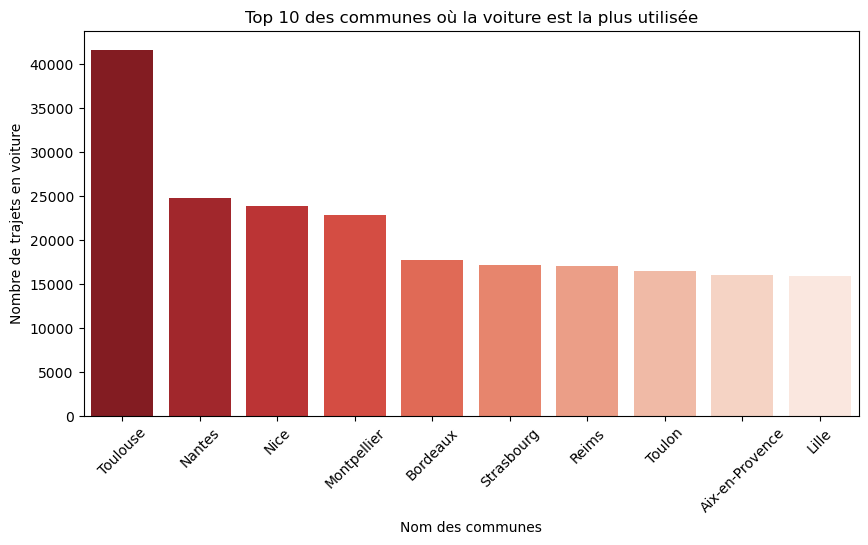


🏙️ Top 10 des communes avec le plus de trajets domicile-travail :
NOM_COMMUNE
Toulouse       81322
Nantes         52702
Nice           51327
Bordeaux       45227
Montpellier    42472
Strasbourg     42271
Lille          36575
Rennes         34181
Reims          26472
Toulon         26343
Name: count, dtype: int64


/tmp/ipykernel_24165/1489238181.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_flux_communes.index, y=top_flux_communes.values, palette='Blues_r')


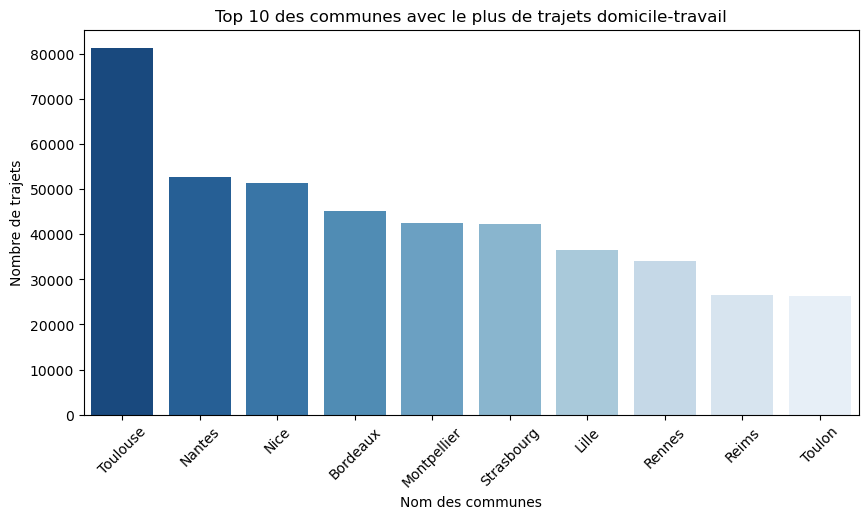

In [17]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns


# 📌 Charger le fichier GeoJSON des communes
url = "https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/communes.geojson"
gdf_communes = gpd.read_file(url)
df_correspondance = gdf_communes[['code', 'nom']].rename(columns={'code': 'COMMUNE', 'nom': 'NOM_COMMUNE'})
df_mobpro_brut = df_mobpro_brut.merge(df_correspondance, on="COMMUNE", how="left")


# 📌 Vérification des modes de transport
mode_mapping = {
    1: "Pas de déplacement",
    2: "Marche à pied",
    3: "Vélo",
    4: "Deux-roues motorisé",
    5: "Voiture, camion ou fourgonnette",
    6: "Transports en commun"
}
df_mobpro_brut['MODE_TRANSPORT'] = df_mobpro_brut['TRANS'].map(mode_mapping)

# 📌 1️⃣ Identifier les zones où la voiture est dominante
df_voiture = df_mobpro_brut[df_mobpro_brut['TRANS'].isin([5])]
top_voiture_communes = df_voiture['NOM_COMMUNE'].value_counts().head(10)

print("\n🚘 Top 10 des communes où la voiture est la plus utilisée :")
print(top_voiture_communes)

# Affichage des noms des communes dans le graphique
plt.figure(figsize=(10, 5))
sns.barplot(x=top_voiture_communes.index, y=top_voiture_communes.values, palette='Reds_r')
plt.xlabel("Nom des communes")  # Affiche les noms
plt.ylabel("Nombre de trajets en voiture")
plt.title("Top 10 des communes où la voiture est la plus utilisée")
plt.xticks(rotation=45)
plt.show()

# 📌 2️⃣ Identifier les communes avec le plus grand nombre de trajets (tous modes confondus)
top_flux_communes = df_mobpro_brut['NOM_COMMUNE'].value_counts().head(10)

print("\n🏙️ Top 10 des communes avec le plus de trajets domicile-travail :")
print(top_flux_communes)

# Affichage des noms des communes dans le graphique
plt.figure(figsize=(10, 5))
sns.barplot(x=top_flux_communes.index, y=top_flux_communes.values, palette='Blues_r')
plt.xlabel("Nom des communes")  # Affiche les noms
plt.ylabel("Nombre de trajets")
plt.title("Top 10 des communes avec le plus de trajets domicile-travail")
plt.xticks(rotation=45)
plt.show()
